# Import Libraries

In [1]:
# data handling
import pandas as pd
import numpy as np
from collections import Counter

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# load numpy array from csv file
from numpy import loadtxt

#for splitting our data
from sklearn.model_selection import train_test_split

#plotting performance
import matplotlib.pyplot as plt

In [ ]:
#!pip install --upgrade tensorflow_hub

In [ ]:
#used for transfer learning
import tensorflow_hub as hub

In [ ]:
#!pip install tensorflow_decision_forests

In [ ]:
#import tensorflow_decision_forests as tfdf #Windows, this library is still not available

In [2]:
#access google drive
#from google.colab import drive, files
#get data from google drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#check that we are using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Utility Functions
Custom functions to help with handling the data

## Text Encoder

In [4]:
def encode_text(text, encode_type, seq_len=3):
  """
  Input txt and outputs tokenised text.
  encode_type: bow = encode documents into vector where the coefficient for 
  each token is based on counting words
  """
  if(encode_type == 'bow'):
    encoder = Tokenizer()# create the tokenizer
    encoder.fit_on_texts(text)
    bow = encoder.texts_to_matrix(text, mode='count')
    # summarize what was learned
    print("Encoder Summary:\n")
    print(encoder.word_counts)
    print(encoder.document_count)
    print(encoder.word_index)
    print(encoder.word_docs)
    print(type(bow))
    print(bow.shape) #8.26gb / 23677 = 0.00035 GB/column if saved to file and 200205 * 0.00035 = 70GB if saved to file!
    return bow
  elif(encode_type == 'sequence'):
    encoder = Tokenizer()# create the tokenizer
    encoder.fit_on_texts(text)
    
    t2s = encoder.texts_to_sequences(text)
    pt2s = pad_sequences(t2s, padding='post', truncating='post', maxlen=seq_len)
    print(pt2s)
    print(type(pt2s))
    print(pt2s.shape)
    return pt2s

  elif(encode_type == 'one-hot'):
    labels = pd.get_dummies(text).values
    print(labels.shape)
    return labels

def train_val_test(X_features, y_target, tc=237, pt_embed=False):
    """
    Splits dataset into 10% for testting, 10% for validation and 
    the remaining 80% for training data. By first spliting data for 
    training and test data (90:10), then training with validation.

    returns X_train, X_test, X_val, max_words, seq_len
    """
    # Reduce word amount to speed up training
    truncate = tc #592 #1183 #2368 #6000 # 23677 
    mxw = 23681 #our vocab value we found during data cleaning
    sl = truncate

    X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(X_features, y_target, test_size=0.1, random_state=42)

    X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(X_train_set, y_train_set, test_size=0.1111, random_state=42)

    print("** Before Truncate **")
    print("Training data shape:", X_train_set.shape)
    print("Training labels shape:", y_train_set.shape)
    print("\n")
    print("Validation data shape:", X_val_set.shape)
    print("Validation labels shape:", y_val_set.shape)
    print("\n")
    print("Test data shape:", X_test_set.shape)
    print("Test labels shape:", y_test_set.shape)

    if(pt_embed):
      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl
    else:
      X_train_set = X_train_set[:, :truncate]
      X_test_set = X_test_set[:, :truncate]
      X_val_set = X_val_set[:, :truncate]

      print("\n")
      print("** After Truncate: " + str(truncate) + " **")
      print("Training data shape:", X_train_set.shape)
      print("Training labels shape:", y_train_set.shape)
      print("\n")
      print("Validation data shape:", X_val_set.shape)
      print("Validation labels shape:", y_val_set.shape)
      print("\n")
      print("Test data shape:", X_test_set.shape)
      print("Test labels shape:", y_test_set.shape)

      return X_train_set, X_test_set, X_val_set, y_train_set, y_val_set, y_test_set, mxw, sl

## Target Encoding: SectionName

### Load prepared SectionName dataset

In [5]:
y = pd.read_csv('/content/drive/MyDrive/data/y_raw.csv') #sectionName only
y.head()

,sectionName
0,football
1,sport
2,world news
3,sport
4,art design


In [6]:
y = y.sectionName.values

### One-Hot-Encode SectionName

In [7]:
y = encode_text(y, encode_type='one-hot')

(14983, 82)


## Model Builder

In [8]:
def build_simple_rnn(id=1000, od=50, il=128, m_type='bow'):
    """
    returns a simple rnn model
    needs input_dim, output_dim and input_length passed.
    """
    if(m_type=='bow'):
      model = tf.keras.Sequential()
      #batch size (numer of observations), #number of columns (timesteps), just have 1 indicator but can increase with more
      model.add(layers.Embedding(input_dim=id, 
                                output_dim=od,
                                input_length=il))
      model.add(layers.GlobalAveragePooling1D())
      model.add(layers.Reshape((1, od)))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model
    elif(m_type=='word_vector'):
      model = tf.keras.Sequential()
      #batch size (numer of observations), #number of columns (timesteps), just have 1 indicator but can increase with more
      model.add(layers.Embedding(input_dim=id, 
                                output_dim=od,
                                input_length=il))
      model.add(layers.Conv1D(25,3,padding='valid',activation='relu',strides=1))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      model.add(layers.Dropout(0.2))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model
    elif(m_type=='pre_trained'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      model.add(layers.Reshape((1, od)))
      model.add(layers.SimpleRNN(8))#embedding dimension #seq_len
      #regularisation layer which randomly turns off 
      #activations of some neurons in the model to prevent overfitting
      model.add(layers.Dropout(0.5))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_lstm(id=1000, od=50, il=128, m_type='single'):
    if(m_type=='single'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      #we need to reshape our data for LSTM. 
      # It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Reshape((128, 1))) # model.add(layers.Reshape((1, od)))
      model.add(layers.LSTM(8))
      model.add(layers.Dropout(0.5))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
      model.summary()
      return model
    elif(m_type=='multi'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      #we need to reshape our data for LSTM. 
      # It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Reshape((1, od))) #model.add(layers.Reshape((128, 1))) 
      model.add(layers.LSTM(8, return_sequences=True))
      model.add(layers.LSTM(8))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_cnn(m_type='mhks_cnn'):
    if(m_type=='mhks_cnn'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      model.add(layers.Reshape((128, 1)))  # Add a time step dimension
      model.add(layers.Conv1D(128, 5, activation='relu'))
      model.add(layers.Conv1D(65, 5, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(10, activation='relu'))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      model.summary()
      return model
    elif(m_type=='mhks_cnn_lstm'):
      model = tf.keras.Sequential()
      # Add the pretrained word embeddings layer
      hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2", input_shape=[], 
                                dtype=tf.string, trainable=True)
      model.add(hub_layer)
      model.add(layers.Reshape((128, 1)))  # Add a time step dimension
      model.add(layers.LSTM(82, return_sequences=True))
      #model.add(layers.Reshape((64, 0))) #we need to reshape our data for LSTM. It expects (batch_size, num_timesteps or sequence_length, num_features)
      model.add(layers.Conv1D(128, 5, activation='relu'))
      model.add(layers.Conv1D(64, 5, activation='relu'))
      model.add(layers.GlobalMaxPooling1D())
      model.add(layers.Dense(10, activation='relu'))
      model.add(layers.Dense(y.shape[1], activation='softmax'))
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
      model.summary()
      return model

def build_random_forest():
      model = tfdf.keras.RandomForestModel(verbose=2)
      return model



# Simple RNN: On-the-fly Word Embeddings

## WebTitle Data

### WebTitle Bag-Of-Words
One hot encoding words and using GlobalAveragePooling1D to encode them.

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

#### Encode Bag-of-Words Representation

In [ ]:
X = encode_text(X, encode_type='bow')

Encoder Summary:

OrderedDict([('saido', 1), ('berahino', 1), ('right', 91), ('attitude', 3), ('hes', 25), ('fit', 16), ('says', 515), ('west', 108), ('broms', 1), ('pulis', 1), ('angelique', 1), ('kerber', 1), ('aims', 16), ('dislodge', 1), ('serena', 9), ('williams', 59), ('world', 295), ('no1', 3), ('spot', 20), ('family', 95), ('building', 13), ('refugee', 35), ('shadow', 15), ('isis', 19), ('exeter', 13), ('keep', 79), ('saracens', 19), ('sights', 5), ('bonus', 11), ('point', 34), ('win', 148), ('worcester', 5), ('exposed', 19), ('photographys', 1), ('fabulous', 5), ('fakes', 2), ('bank', 81), ('england', 279), ('governor', 12), ('caught', 14), ('bluffing', 1), ('interest', 25), ('rates', 25), ('senior', 15), ('tory', 73), ('urges', 41), ('eurosceptics', 1), ('show', 106), ('integrity', 8), ('vote', 82), ('leave', 70), ('eu', 142), ('holding', 7), ('back', 233), ('growth', 23), ('solar', 15), ('power', 92), ('herons', 1), ('review', 977), ('feral', 2), ('smash', 5), ('grab', 10), 

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 23677)
Training labels shape: (11985, 82)


Validation data shape: (1499, 23677)
Validation labels shape: (11985, 82)


Test data shape: (1499, 23677)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle BOW
Input will be passed to an basic RNN layer - sequences will be generated 

In [ ]:
RNN_model = build_simple_rnn(max_words, 50, seq_len, m_type='bow')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d_3   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 reshape_1 (Reshape)         (None, 1, 50)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 472       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 82)                738       
                                                      

#### Train Simple RNN Model using webTitle BOW

In [ ]:
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 11s 25ms/step - loss: 3.6251 - accuracy: 0.0759 - val_loss: 3.2908 - val_accuracy: 0.1254
Epoch 2/10
375/375 [==============================] - 7s 20ms/step - loss: 3.3199 - accuracy: 0.1002 - val_loss: 3.2721 - val_accuracy: 0.1254
Epoch 3/10
375/375 [==============================] - 9s 24ms/step - loss: 3.3151 - accuracy: 0.1038 - val_loss: 3.2711 - val_accuracy: 0.1254
Epoch 4/10
375/375 [==============================] - 7s 20ms/step - loss: 3.3053 - accuracy: 0.1038 - val_loss: 3.2696 - val_accuracy: 0.1254
Epoch 5/10
375/375 [==============================] - 9s 23ms/step - loss: 3.3018 - accuracy: 0.1041 - val_loss: 3.2693 - val_accuracy: 0.1254
Epoch 6/10
375/375 [==============================] - 8s 21ms/step - loss: 3.2979 - accuracy: 0.1064 - val_loss: 3.2682 - val_accuracy: 0.1254
Epoch 7/10
375/375 [==============================] - 8s 22ms/step - loss: 3.2992 - accuracy: 0.1052 - val_loss: 3.2693 - val_accuracy: 0.125

#### Evaluation of Simple RNN Model using webTitle BOW

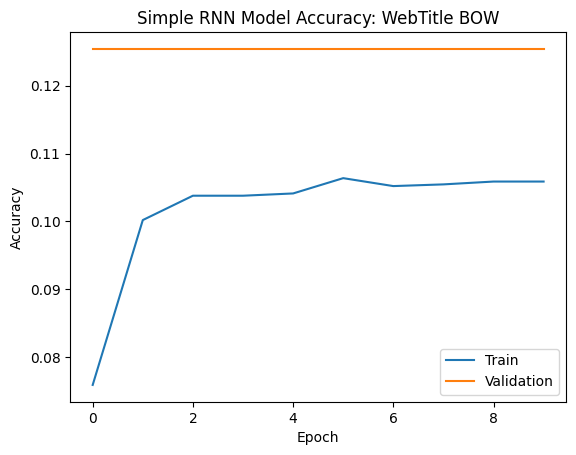

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Simple RNN Model Accuracy: WebTitle BOW')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

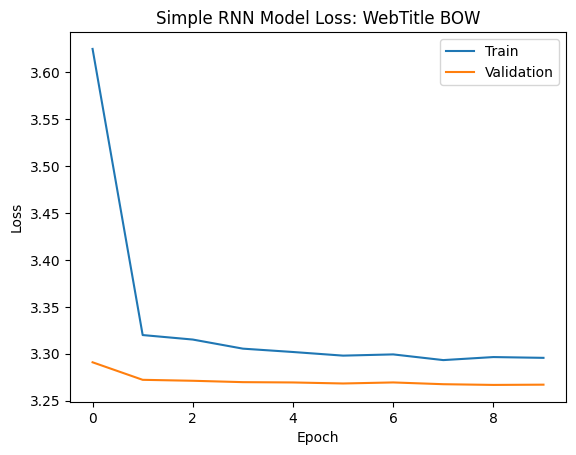

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Simple RNN Model Loss: WebTitle BOW')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("RNN - WebTitle - BOW")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle - BOW
47/47 - 0s - loss: 3.3130 - accuracy: 0.0894 - 186ms/epoch - 4ms/step
RNN Test Loss 3.313
RNN Test Accuracy 0.089


#### Save Simple RNN Model using webTitle Bag of words 

In [ ]:
RNN_model.save('/content/rnn_model-wt-bow')

In [ ]:
#!zip -r rnn_model-wt-bow.zip rnn_model-wt-bow

  adding: rnn_model-wt-bow/ (stored 0%)
  adding: rnn_model-wt-bow/keras_metadata.pb (deflated 87%)
  adding: rnn_model-wt-bow/assets/ (stored 0%)
  adding: rnn_model-wt-bow/fingerprint.pb (stored 0%)
  adding: rnn_model-wt-bow/variables/ (stored 0%)
  adding: rnn_model-wt-bow/variables/variables.index (deflated 59%)
  adding: rnn_model-wt-bow/variables/variables.data-00000-of-00001 (deflated 69%)
  adding: rnn_model-wt-bow/saved_model.pb (deflated 90%)


In [ ]:
files.download("/content/rnn_model-wt-bow.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### webTitle Sequence

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

#### Encode Word Sequence Vector Representation

In [ ]:
X = encode_text(X, encode_type='sequence', seq_len=237) #592 #1183 #2368 #6000 # 23677

[[11115 11116   118 ...     0     0     0]
 [11119 11120  1430 ...     0     0     0]
 [  105  1775   534 ...     0     0     0]
 ...
 [ 3954   215   252 ...     0     0     0]
 [ 1536  4797    42 ...     0     0     0]
 [11006   911 10361 ...     0     0     0]]
<class 'numpy.ndarray'>
(14983, 237)


#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle T2S

In [ ]:
RNN_model = build_simple_rnn(max_words, 50, seq_len, m_type='word_vector')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 237, 50)           1184050   
                                                                 
 conv1d (Conv1D)             (None, 235, 25)           3775      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 8)                 272       
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 82)                738       
                                                                 
Total params: 1,188,835
Trainable params: 1,188,835
Non-trainable params: 0
_________________________________________________________________


#### Train Simple RNN Model using webTitle T2S

In [ ]:
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 37s 92ms/step - loss: 3.6511 - accuracy: 0.0865 - val_loss: 3.3006 - val_accuracy: 0.1254
Epoch 2/10
375/375 [==============================] - 35s 92ms/step - loss: 3.3306 - accuracy: 0.0972 - val_loss: 3.2769 - val_accuracy: 0.1254
Epoch 3/10
375/375 [==============================] - 38s 101ms/step - loss: 3.3131 - accuracy: 0.0995 - val_loss: 3.2702 - val_accuracy: 0.1254
Epoch 4/10
375/375 [==============================] - 34s 92ms/step - loss: 3.3085 - accuracy: 0.0980 - val_loss: 3.2686 - val_accuracy: 0.1254
Epoch 5/10
375/375 [==============================] - 34s 92ms/step - loss: 3.3040 - accuracy: 0.1008 - val_loss: 3.2712 - val_accuracy: 0.1254
Epoch 6/10
375/375 [==============================] - 36s 96ms/step - loss: 3.2995 - accuracy: 0.1048 - val_loss: 3.2692 - val_accuracy: 0.1254
Epoch 7/10
375/375 [==============================] - 34s 91ms/step - loss: 3.2982 - accuracy: 0.1038 - val_loss: 3.2697 - val_accuracy

#### Evaluation of Simple RNN Model using webTitle T2S

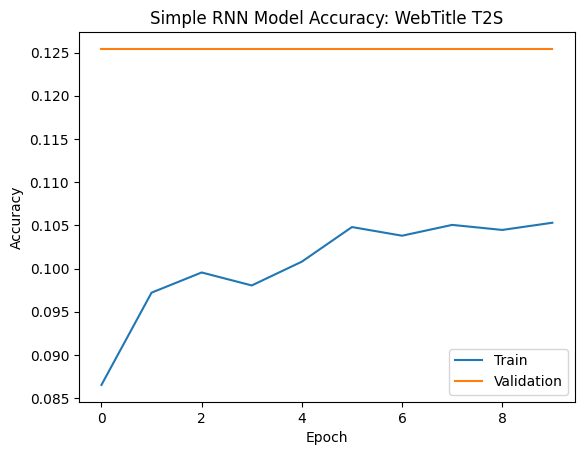

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Simple RNN Model Accuracy: WebTitle T2S')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

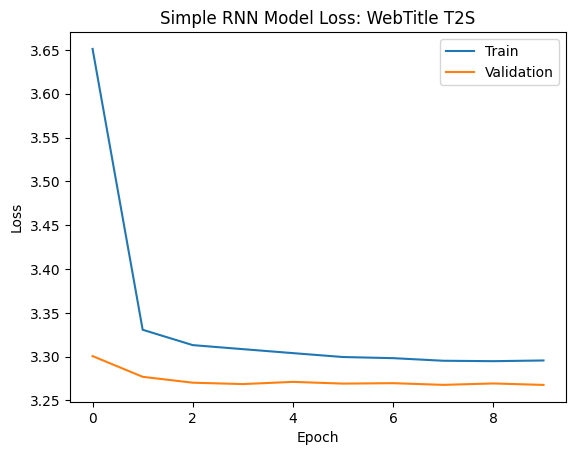

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Simple RNN Model Loss: WebTitle T2S')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("RNN - WebTitle - T2S")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle - T2S
47/47 - 1s - loss: 3.3135 - accuracy: 0.0894 - 764ms/epoch - 16ms/step
RNN Test Loss 3.314
RNN Test Accuracy 0.089


#### Save Simple RNN Model using webTitle Bag of words 

In [ ]:
RNN_model.save('/content/rnn_model-wt-t2s')

In [ ]:
!zip -r rnn_model-wt-t2s.zip rnn_model-wt-t2s

  adding: rnn_model-wt-t2s/ (stored 0%)
  adding: rnn_model-wt-t2s/keras_metadata.pb (deflated 88%)
  adding: rnn_model-wt-t2s/assets/ (stored 0%)
  adding: rnn_model-wt-t2s/fingerprint.pb (stored 0%)
  adding: rnn_model-wt-t2s/variables/ (stored 0%)
  adding: rnn_model-wt-t2s/variables/variables.index (deflated 60%)
  adding: rnn_model-wt-t2s/variables/variables.data-00000-of-00001 (deflated 52%)
  adding: rnn_model-wt-t2s/saved_model.pb (deflated 89%)


In [ ]:
files.download("/content/rnn_model-wt-t2s.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## WebTitle & BodyContent (Additional Data)

### WebTitle & BodyContent Bag-Of-Words

#### Replace webTitle dataset with prepared webTitle & BodyContent dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt_bc.csv') #WebTitle only
X.head()

,webTitle_bodyContent
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis 9 june 201...
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes 1840 hippo...


In [ ]:
X = X.webTitle_bodyContent.values

In [ ]:
print(X.shape)

(14983,)

#### Encode Bag-of-Words Representation

In [ ]:
X = encode_text(X, encode_type='bow')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(X)

[[0. 5. 2. ... 0. 0. 0.]
 [0. 2. 2. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 6. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 6. 1. ... 1. 1. 1.]]


In [ ]:
print(X.shape)

(14983, 200205)


In [ ]:
X = X[:, :23677] #colab was crashing as too high

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 23677)
Training labels shape: (11985, 82)


Validation data shape: (1499, 23677)
Validation labels shape: (11985, 82)


Test data shape: (1499, 23677)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (11985, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle & BodyContent Bag of words 
Input will be passed to an basic RNN layer - sequences will be generated 

In [ ]:
RNN_model = build_simple_rnn(max_words, 50, seq_len, m_type='bow')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 237, 50)           1184050   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 50)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 472       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 82)                738       
                                                        

#### Train Simple RNN Model using webTitle T2S

In [ ]:
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 11s 23ms/step - loss: 3.6123 - accuracy: 0.0860 - val_loss: 3.2868 - val_accuracy: 0.1254
Epoch 2/10
375/375 [==============================] - 9s 23ms/step - loss: 3.3231 - accuracy: 0.1017 - val_loss: 3.2719 - val_accuracy: 0.1254
Epoch 3/10
375/375 [==============================] - 8s 20ms/step - loss: 3.3086 - accuracy: 0.1019 - val_loss: 3.2704 - val_accuracy: 0.1254
Epoch 4/10
375/375 [==============================] - 9s 23ms/step - loss: 3.3054 - accuracy: 0.1026 - val_loss: 3.2680 - val_accuracy: 0.1254
Epoch 5/10
375/375 [==============================] - 8s 22ms/step - loss: 3.2991 - accuracy: 0.1036 - val_loss: 3.2669 - val_accuracy: 0.1254
Epoch 6/10
375/375 [==============================] - 9s 23ms/step - loss: 3.2992 - accuracy: 0.1033 - val_loss: 3.2669 - val_accuracy: 0.1254
Epoch 7/10
375/375 [==============================] - 8s 20ms/step - loss: 3.2929 - accuracy: 0.1053 - val_loss: 3.2639 - val_accuracy: 0.125

#### Evaluation of Simple RNN Model using webTitle & BodyContent Bag of words 

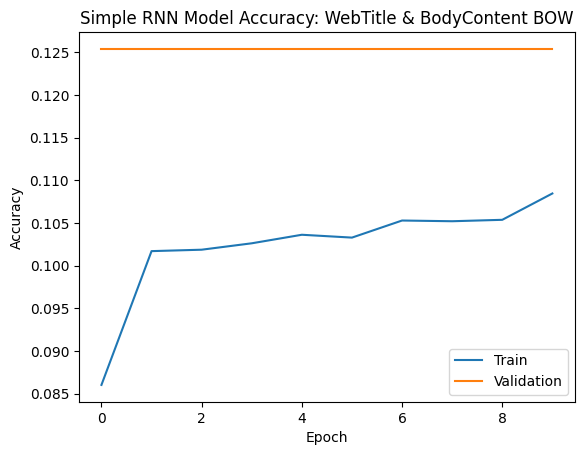

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Simple RNN Model Accuracy: WebTitle & BodyContent BOW')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

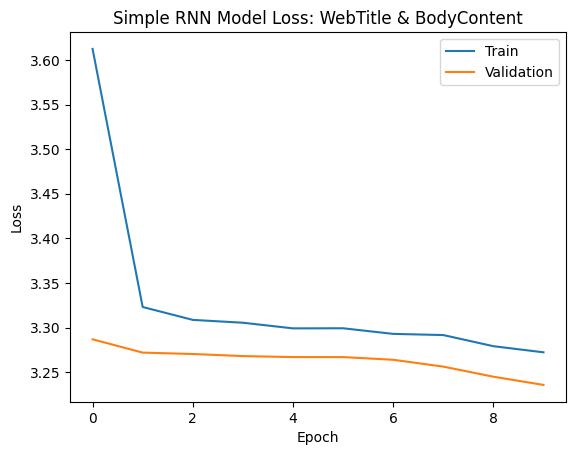

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Simple RNN Model Loss: WebTitle & BodyContent')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("RNN - WebTitle & BodyContent - BOW")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", loss_and_metrics[0])
print("RNN Test Accuracy", loss_and_metrics[1])

RNN - WebTitle & BodyContent - BOW
47/47 - 0s - loss: 3.2881 - accuracy: 0.0894 - 135ms/epoch - 3ms/step
RNN Test Loss 3.2880752086639404
RNN Test Accuracy 0.08939293026924133


#### Save Simple RNN Model using webTitle & BodyContent Bag of words 

In [ ]:
RNN_model.save('/content/rnn_model-wt-bc-bow')

In [ ]:
!zip -r rnn_model-wt-bc-bow.zip rnn_model-wt-bc-bow

  adding: rnn_model-wt-bc-bow/ (stored 0%)
  adding: rnn_model-wt-bc-bow/keras_metadata.pb (deflated 87%)
  adding: rnn_model-wt-bc-bow/assets/ (stored 0%)
  adding: rnn_model-wt-bc-bow/fingerprint.pb (stored 0%)
  adding: rnn_model-wt-bc-bow/variables/ (stored 0%)
  adding: rnn_model-wt-bc-bow/variables/variables.index (deflated 59%)
  adding: rnn_model-wt-bc-bow/variables/variables.data-00000-of-00001 (deflated 69%)
  adding: rnn_model-wt-bc-bow/saved_model.pb (deflated 90%)


In [ ]:
files.download("/content/rnn_model-wt-bc-bow.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### WebTitle & BodyContent Sequence

#### Reload prepared WebTitle & BodyContent dataset

In [9]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt_bc.csv') #WebTitle only
X.head()

,webTitle_bodyContent
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis 9 june 201...
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes 1840 hippo...


In [10]:
X = X.webTitle_bodyContent.values

#### Encode Word Sequence Vector Representation

In [11]:
X = encode_text(X, encode_type='sequence', seq_len=237) #592 #1183 #2368 #6000 # 23677

[[42542 37092    62 ...   518  3481   153]
 [26864 22351  3413 ...     6  1053  1377]
 [   79   576  2128 ...     4   151 24291]
 ...
 [11541   662  1212 ...   276 33900  3329]
 [ 3002 10330   206 ...     0     0     0]
 [12301   211 24372 ...  7433  2981    12]]
<class 'numpy.ndarray'>
(14983, 237)


In [12]:
print(X.shape)

(14983, 237)


In [13]:
np.any(X < 0)

False

#### Split WebTitle, BodyContent & sectionName into 80% training, 10% test & 10% validation datasets

In [14]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (1499, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985, 82)


Validation data shape: (1499, 237)
Validation labels shape: (1499, 82)


Test data shape: (1499, 237)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using WebTitle & BodyContent T2S

In [15]:
RNN_model = build_simple_rnn(max_words, 50, seq_len, m_type='word_vector')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 237, 50)           1184050   
                                                                 
 conv1d (Conv1D)             (None, 235, 25)           3775      
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 272       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 82)                738       
                                                                 
Total params: 1,188,835
Trainable params: 1,188,835
Non-trainable params: 0
_________________________________________________________________


#### Train Simple RNN Model using WebTitle & BodyContent T2S

In [16]:
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 150s 390ms/step - loss: 3.6511 - accuracy: 0.0748 - val_loss: 3.3065 - val_accuracy: 0.1254
Epoch 2/10
375/375 [==============================] - 117s 312ms/step - loss: 3.3280 - accuracy: 0.0993 - val_loss: 3.2759 - val_accuracy: 0.1254
Epoch 3/10
375/375 [==============================] - 105s 280ms/step - loss: 3.3010 - accuracy: 0.0990 - val_loss: 3.2740 - val_accuracy: 0.1154
Epoch 4/10
375/375 [==============================] - 97s 260ms/step - loss: 3.2151 - accuracy: 0.1212 - val_loss: 3.2751 - val_accuracy: 0.1161
Epoch 5/10
375/375 [==============================] - 97s 259ms/step - loss: 3.0860 - accuracy: 0.1439 - val_loss: 3.2916 - val_accuracy: 0.1114
Epoch 6/10
375/375 [==============================] - 99s 265ms/step - loss: 2.9249 - accuracy: 0.1735 - val_loss: 3.3251 - val_accuracy: 0.0967
Epoch 7/10
375/375 [==============================] - 98s 261ms/step - loss: 2.7528 - accuracy: 0.2063 - val_loss: 3.3973 - val

#### Evaluation of Simple RNN Model using WebTitle & BodyContent T2S

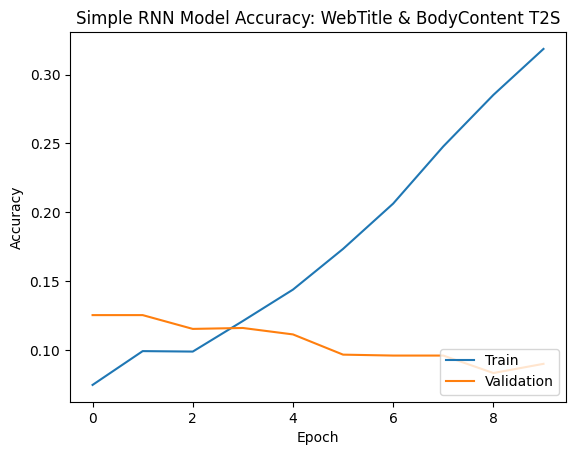

In [17]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Simple RNN Model Accuracy: WebTitle & BodyContent T2S')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

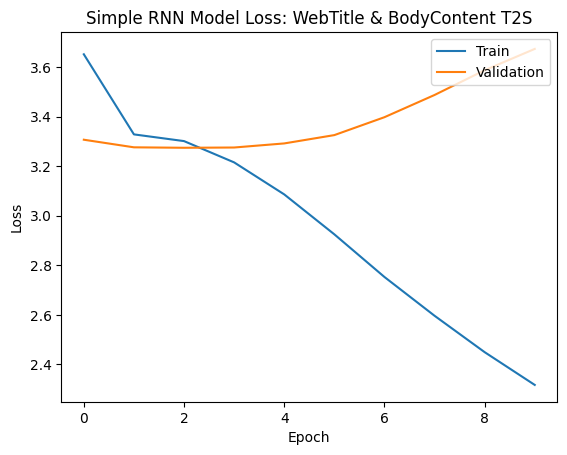

In [18]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Simple RNN Model Loss: WebTitle & BodyContent T2S')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [19]:
print("RNN - WebTitle & BodyContent - T2S")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle & BodyContent - T2S
47/47 - 1s - loss: 3.6933 - accuracy: 0.0847 - 899ms/epoch - 19ms/step
RNN Test Loss 3.693
RNN Test Accuracy 0.085


#### Save Simple RNN Model using webTitle Bag of words 

In [20]:
RNN_model.save('/content/rnn_model_wt_bc_t2s')

In [21]:
!zip -r rnn_model_wt_bc_t2s.zip rnn_model_wt_bc_t2s

  adding: rnn_model_wt_bc_t2s/ (stored 0%)
  adding: rnn_model_wt_bc_t2s/assets/ (stored 0%)
  adding: rnn_model_wt_bc_t2s/saved_model.pb (deflated 89%)
  adding: rnn_model_wt_bc_t2s/variables/ (stored 0%)
  adding: rnn_model_wt_bc_t2s/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: rnn_model_wt_bc_t2s/variables/variables.index (deflated 60%)
  adding: rnn_model_wt_bc_t2s/keras_metadata.pb (deflated 88%)
  adding: rnn_model_wt_bc_t2s/fingerprint.pb (stored 0%)


In [22]:
files.download("/content/rnn_model_wt_bc_t2s.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Simple RNN: Pretrained Word Embeddings

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build Simple RNN Model using webTitle pretrained embeddings

In [ ]:
RNN_model = build_simple_rnn(max_words, 128, seq_len, m_type='pre_trained')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_11 (KerasLayer)  (None, 128)              124642688 
                                                                 
 reshape_10 (Reshape)        (None, 1, 128)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 8)                 1096      
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 82)                738       
                                                                 
Total params: 124,644,522
Trainable params: 124,644,522
Non-trainable params: 0
_________________________________________________________________


#### Train Simple RNN Model using webTitle PTE

In [ ]:
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 1264s 3s/step - loss: 3.6118 - accuracy: 0.1181 - val_loss: 3.1412 - val_accuracy: 0.1788
Epoch 2/10
375/375 [==============================] - 1238s 3s/step - loss: 2.9517 - accuracy: 0.2154 - val_loss: 2.7993 - val_accuracy: 0.2582
Epoch 3/10
375/375 [==============================] - 1231s 3s/step - loss: 2.4805 - accuracy: 0.3286 - val_loss: 2.5483 - val_accuracy: 0.3222
Epoch 4/10
375/375 [==============================] - 1245s 3s/step - loss: 2.0425 - accuracy: 0.4565 - val_loss: 2.4081 - val_accuracy: 0.3809
Epoch 5/10
375/375 [==============================] - 1234s 3s/step - loss: 1.6958 - accuracy: 0.5514 - val_loss: 2.3457 - val_accuracy: 0.4023
Epoch 6/10
375/375 [==============================] - 1241s 3s/step - loss: 1.4036 - accuracy: 0.6340 - val_loss: 2.3320 - val_accuracy: 0.4149
Epoch 7/10
375/375 [==============================] - 1236s 3s/step - loss: 1.1981 - accuracy: 0.6748 - val_loss: 2.3452 - val_accuracy:

#### Evaluation of Simple RNN Model using webTitle T2S

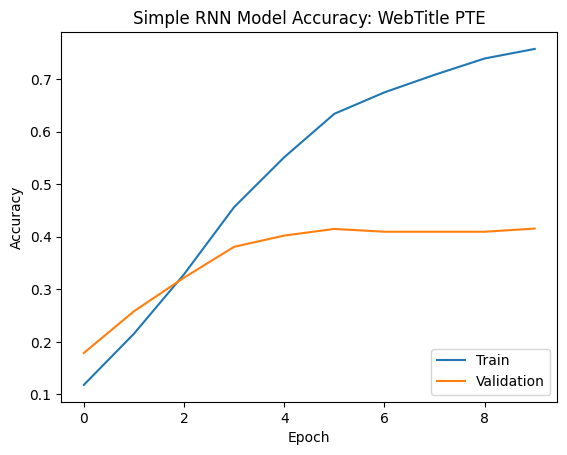

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_history.history['accuracy'])
plt.plot(RNN_history.history['val_accuracy'])
plt.title('Simple RNN Model Accuracy: WebTitle PTE')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

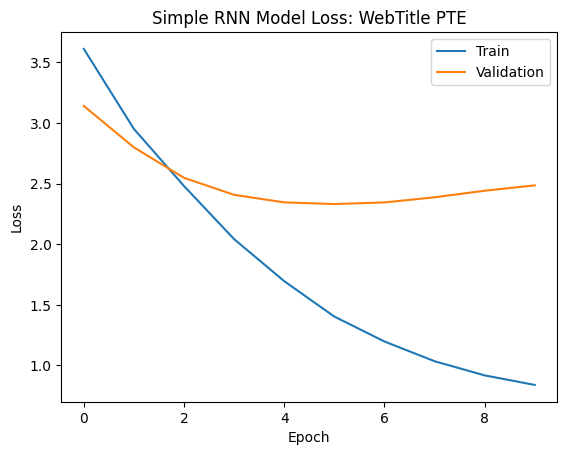

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_history.history['loss'])
plt.plot(RNN_history.history['val_loss'])
plt.title('Simple RNN Model Loss: WebTitle PTE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("RNN - WebTitle - PTE")
loss_and_metrics = RNN_model.evaluate(X_test, y_test, verbose=2)
print("RNN Test Loss", round(loss_and_metrics[0], 3))
print("RNN Test Accuracy", round(loss_and_metrics[1], 3))

RNN - WebTitle - PTE
47/47 - 21s - loss: 2.4943 - accuracy: 0.4136 - 21s/epoch - 447ms/step
RNN Test Loss 2.494
RNN Test Accuracy 0.414


#### Save Simple RNN Model using webTitle Bag of words 

In [ ]:
RNN_model.save('/content/rnn_model-wt-pte')

In [ ]:
#!zip -r rnn_model-wt-pte.zip rnn_model-wt-pte

  adding: rnn_model-wt-pte/ (stored 0%)
  adding: rnn_model-wt-pte/keras_metadata.pb (deflated 86%)
  adding: rnn_model-wt-pte/assets/ (stored 0%)
  adding: rnn_model-wt-pte/assets/tokens.txt (deflated 43%)
  adding: rnn_model-wt-pte/fingerprint.pb (stored 0%)
  adding: rnn_model-wt-pte/variables/ (stored 0%)
  adding: rnn_model-wt-pte/variables/variables.index (deflated 59%)
  adding: rnn_model-wt-pte/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: rnn_model-wt-pte/saved_model.pb (deflated 89%)


In [ ]:
files.download("/content/rnn_model-wt-pte.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Single LSTM

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build LSTM Model

In [ ]:
LSTM_model = build_lstm(max_words, 128, seq_len, m_type='single')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 82)                410       
                                                                 
Total params: 124,643,194
Trainable params: 124,643,194
Non-trainable params: 0
_________________________________________________________________


#### Train LSTM Model

In [ ]:
LSTM_history = LSTM_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 466s 1s/step - loss: 3.9034 - accuracy: 0.0722 - val_loss: 3.4207 - val_accuracy: 0.1254
Epoch 2/10
375/375 [==============================] - 463s 1s/step - loss: 3.4531 - accuracy: 0.0955 - val_loss: 3.3008 - val_accuracy: 0.1254
Epoch 3/10
375/375 [==============================] - 462s 1s/step - loss: 3.3988 - accuracy: 0.1006 - val_loss: 3.2779 - val_accuracy: 0.1254
Epoch 4/10
375/375 [==============================] - 463s 1s/step - loss: 3.3714 - accuracy: 0.0992 - val_loss: 3.2671 - val_accuracy: 0.1254
Epoch 5/10
375/375 [==============================] - 463s 1s/step - loss: 3.3387 - accuracy: 0.1028 - val_loss: 3.2501 - val_accuracy: 0.1254
Epoch 6/10
375/375 [==============================] - 463s 1s/step - loss: 3.2854 - accuracy: 0.1041 - val_loss: 3.2057 - val_accuracy: 0.1254
Epoch 7/10
375/375 [==============================] - 483s 1s/step - loss: 3.2196 - accuracy: 0.1059 - val_loss: 3.1725 - val_accuracy: 0.1254

#### Evaluation of LSTM Model

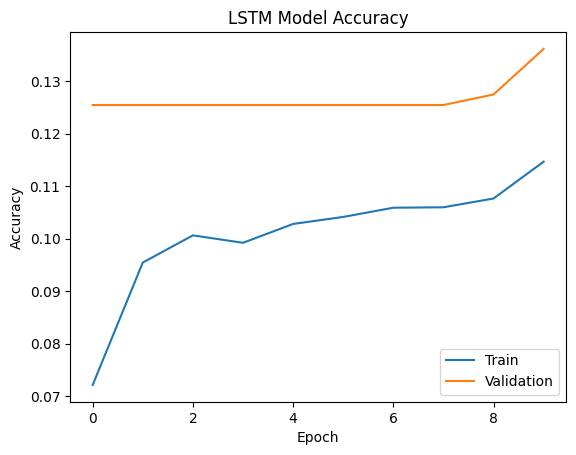

In [ ]:
# Plot training & validation accuracy values
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

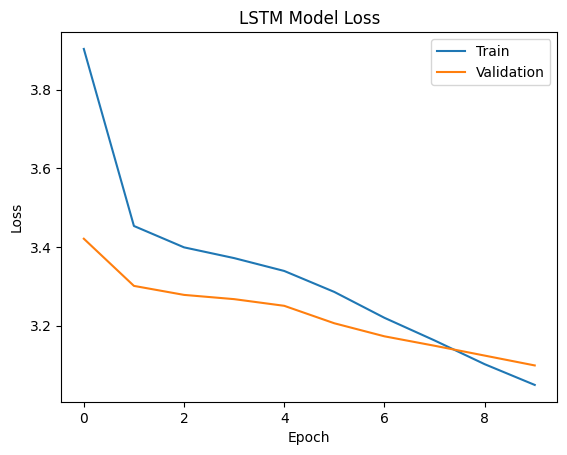

In [ ]:
# Plot training & validation loss values
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("LSTM")
loss_and_metrics = LSTM_model.evaluate(X_test, y_test, verbose=2)
print("LSTM Test Loss", round(loss_and_metrics[0], 3))
print("LSTM Test Accuracy", round(loss_and_metrics[1], 3))

LSTM
47/47 - 1s - loss: 3.1792 - accuracy: 0.0967 - 548ms/epoch - 12ms/step
LSTM Test Loss 3.179
LSTM Test Accuracy 0.097


#### Save LSTM Model

In [ ]:
LSTM_model.save('/content/lstm_model')

INFO:tensorflow:Assets written to: ./models/lstm_model\assets


INFO:tensorflow:Assets written to: ./models/lstm_model\assets


In [ ]:
!zip -r lstm_model.zip lstm_model

  adding: rnn_model-wt-pte/ (stored 0%)
  adding: rnn_model-wt-pte/keras_metadata.pb (deflated 86%)
  adding: rnn_model-wt-pte/assets/ (stored 0%)
  adding: rnn_model-wt-pte/assets/tokens.txt (deflated 43%)
  adding: rnn_model-wt-pte/fingerprint.pb (stored 0%)
  adding: rnn_model-wt-pte/variables/ (stored 0%)
  adding: rnn_model-wt-pte/variables/variables.index (deflated 59%)
  adding: rnn_model-wt-pte/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: rnn_model-wt-pte/saved_model.pb (deflated 89%)


In [ ]:
files.download("/content/lstm_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Multi-Layer LSTM Model

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build Multi-Layer LSTM Model

In [ ]:
LSTM_model = build_lstm(max_words, 128, seq_len, m_type='multi')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 1, 8)              4384      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 82)                738       
                                                                 
Total params: 124,648,354
Trainable params: 124,648,354
Non-trainable params: 0
_________________________________________________________________


#### Train Multi-Layer LSTM Model

In [ ]:
LSTM_history = LSTM_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 452s 1s/step - loss: 3.6765 - accuracy: 0.0955 - val_loss: 3.2861 - val_accuracy: 0.1254
Epoch 2/10
375/375 [==============================] - 447s 1s/step - loss: 3.2432 - accuracy: 0.1064 - val_loss: 3.2070 - val_accuracy: 0.1288
Epoch 3/10
375/375 [==============================] - 447s 1s/step - loss: 3.1318 - accuracy: 0.1111 - val_loss: 3.1308 - val_accuracy: 0.1294
Epoch 4/10
375/375 [==============================] - 447s 1s/step - loss: 2.9690 - accuracy: 0.1297 - val_loss: 3.0291 - val_accuracy: 0.1474
Epoch 5/10
375/375 [==============================] - 447s 1s/step - loss: 2.7571 - accuracy: 0.1673 - val_loss: 2.9764 - val_accuracy: 0.1568
Epoch 6/10
375/375 [==============================] - 447s 1s/step - loss: 2.5467 - accuracy: 0.2028 - val_loss: 2.9612 - val_accuracy: 0.1628
Epoch 7/10
375/375 [==============================] - 447s 1s/step - loss: 2.3628 - accuracy: 0.2326 - val_loss: 2.9795 - val_accuracy: 0.1928

#### Evaluation of Multi-Layer LSTM Model

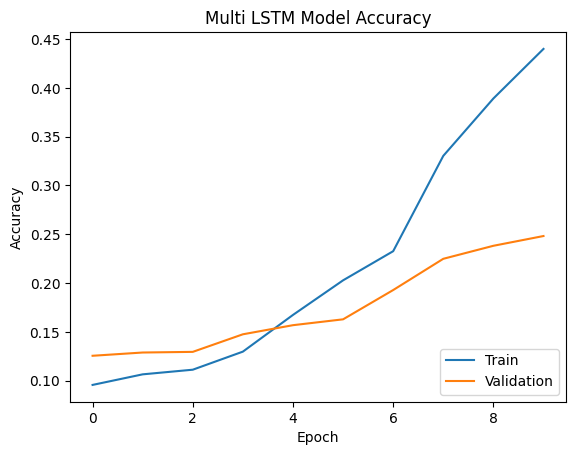

In [ ]:
# Plot training & validation accuracy values
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('Multi LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

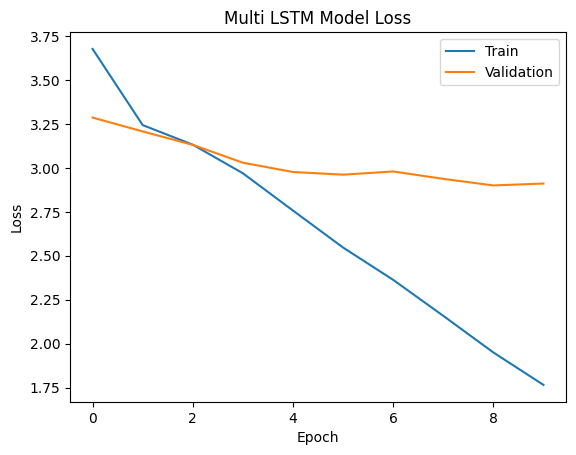

In [ ]:
# Plot training & validation loss values
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('Multi LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("Multi LSTM")
loss_and_metrics = LSTM_model.evaluate(X_test, y_test, verbose=2)
print("Multi LSTM Test Loss", round(loss_and_metrics[0], 3))
print("Multi LSTM Test Accuracy", round(loss_and_metrics[1], 3))

Multi LSTM
47/47 - 0s - loss: 3.0418 - accuracy: 0.2248 - 465ms/epoch - 10ms/step
Multi LSTM Test Loss 3.042
Multi LSTM Test Accuracy 0.225


#### Save Multi-Layer LSTM Model

In [ ]:
LSTM_model.save('/content/multi-lstm_model')

INFO:tensorflow:Assets written to: ./models/multi-lstm_model\assets


INFO:tensorflow:Assets written to: ./models/multi-lstm_model\assets


In [ ]:
!zip -r multi-lstm_model.zip multi-lstm_model

  adding: rnn_model-wt-pte/ (stored 0%)
  adding: rnn_model-wt-pte/keras_metadata.pb (deflated 86%)
  adding: rnn_model-wt-pte/assets/ (stored 0%)
  adding: rnn_model-wt-pte/assets/tokens.txt (deflated 43%)
  adding: rnn_model-wt-pte/fingerprint.pb (stored 0%)
  adding: rnn_model-wt-pte/variables/ (stored 0%)
  adding: rnn_model-wt-pte/variables/variables.index (deflated 59%)
  adding: rnn_model-wt-pte/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: rnn_model-wt-pte/saved_model.pb (deflated 89%)


In [ ]:
files.download("/content/multi-lstm_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CNN Model

#### Load prepared webTitle dataset

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [ ]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [ ]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build CNN Model

In [ ]:
CNN_model = build_cnn(m_type='mhks_cnn')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 65)           41665     
                                                                 
 global_max_pooling1d (Globa  (None, 65)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                660       
                                                        

#### Train CNN Model

In [ ]:
CNN_history = CNN_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 38s 68ms/step - loss: 3.4877 - accuracy: 0.0919 - val_loss: 3.2118 - val_accuracy: 0.1388
Epoch 2/10
375/375 [==============================] - 15s 39ms/step - loss: 2.8887 - accuracy: 0.1777 - val_loss: 2.8641 - val_accuracy: 0.2248
Epoch 3/10
375/375 [==============================] - 15s 40ms/step - loss: 1.8087 - accuracy: 0.4706 - val_loss: 3.2053 - val_accuracy: 0.2475
Epoch 4/10
375/375 [==============================] - 14s 38ms/step - loss: 0.9184 - accuracy: 0.7511 - val_loss: 3.8561 - val_accuracy: 0.2769
Epoch 5/10
375/375 [==============================] - 14s 37ms/step - loss: 0.4397 - accuracy: 0.8853 - val_loss: 4.7710 - val_accuracy: 0.2655
Epoch 6/10
375/375 [==============================] - 14s 38ms/step - loss: 0.2358 - accuracy: 0.9460 - val_loss: 5.6419 - val_accuracy: 0.2308
Epoch 7/10
375/375 [==============================] - 14s 37ms/step - loss: 0.1406 - accuracy: 0.9682 - val_loss: 6.0494 - val_accuracy:

#### Evaluation of CNN Model

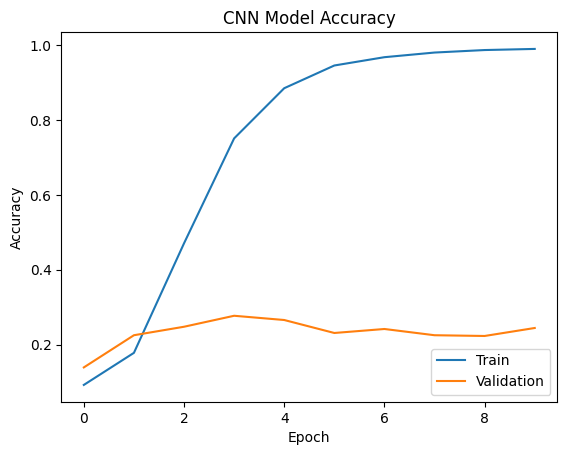

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

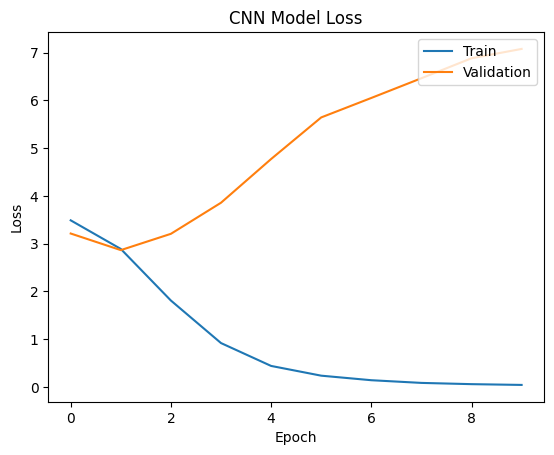

In [ ]:
# Plot training & validation loss values
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
print("CNN")
loss_and_metrics = CNN_model.evaluate(X_test, y_test, verbose=2)
print("CNN Test Loss", round(loss_and_metrics[0], 3))
print("CNN Test Accuracy", round(loss_and_metrics[1], 3))

CNN
47/47 - 1s - loss: 7.7222 - accuracy: 0.2288 - 526ms/epoch - 11ms/step
CNN Test Loss 7.722
CNN Test Accuracy 0.229


#### Save CNN Model

In [ ]:
CNN_model.save('/content/cnn_model')

In [ ]:
!zip -r cnn_model.zip cnn_model

  adding: cnn_model/ (stored 0%)
  adding: cnn_model/assets/ (stored 0%)
  adding: cnn_model/assets/tokens.txt (deflated 43%)
  adding: cnn_model/saved_model.pb (deflated 87%)
  adding: cnn_model/variables/ (stored 0%)
  adding: cnn_model/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: cnn_model/variables/variables.index (deflated 62%)
  adding: cnn_model/keras_metadata.pb (deflated 89%)
  adding: cnn_model/fingerprint.pb (stored 0%)


In [ ]:
files.download("/content/cnn_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CNN+LSTM Model

#### Load prepared webTitle dataset

In [9]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [10]:
X = X.webTitle.values

In [ ]:
type(X)

numpy.ndarray

#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [11]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237, pt_embed=True)

** Before Truncate **
Training data shape: (11985,)
Training labels shape: (11985, 82)


Validation data shape: (1499,)
Validation labels shape: (1499, 82)


Test data shape: (1499,)
Test labels shape: (1499, 82)


#### Build CNN & LSTM Model

In [12]:
CNN_LSTM_model = build_cnn(m_type='mhks_cnn_lstm')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 128, 82)           27552     
                                                                 
 conv1d (Conv1D)             (None, 124, 128)          52608     
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 64)           41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                        

#### Train CNN & LSTM Model

In [13]:
CNN_LSTM_history = CNN_LSTM_model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10) #batch_size=32

Epoch 1/10
375/375 [==============================] - 36s 73ms/step - loss: 3.4897 - accuracy: 0.0897 - val_loss: 3.0580 - val_accuracy: 0.1474
Epoch 2/10
375/375 [==============================] - 18s 47ms/step - loss: 2.7526 - accuracy: 0.2052 - val_loss: 2.8091 - val_accuracy: 0.2235
Epoch 3/10
375/375 [==============================] - 17s 45ms/step - loss: 2.1902 - accuracy: 0.3458 - val_loss: 2.8981 - val_accuracy: 0.2462
Epoch 4/10
375/375 [==============================] - 16s 43ms/step - loss: 1.7016 - accuracy: 0.4827 - val_loss: 3.0909 - val_accuracy: 0.2742
Epoch 5/10
375/375 [==============================] - 16s 42ms/step - loss: 1.2790 - accuracy: 0.6014 - val_loss: 3.9459 - val_accuracy: 0.2628
Epoch 6/10
375/375 [==============================] - 16s 42ms/step - loss: 0.9268 - accuracy: 0.7067 - val_loss: 4.4748 - val_accuracy: 0.2495
Epoch 7/10
375/375 [==============================] - 16s 42ms/step - loss: 0.6908 - accuracy: 0.7905 - val_loss: 5.4290 - val_accuracy:

#### Evaluation of CNN & LSTM Model

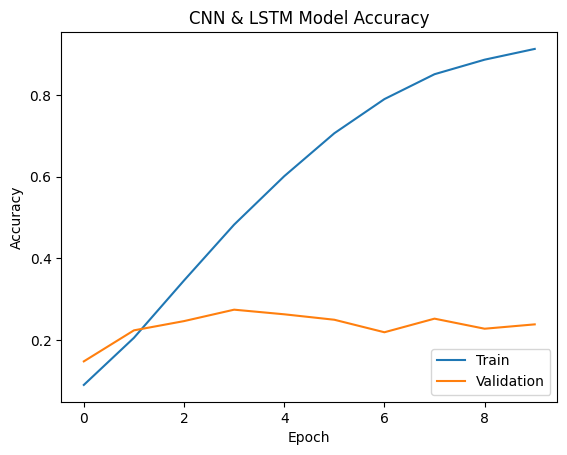

In [14]:
# Plot training & validation accuracy values
plt.plot(CNN_LSTM_history.history['accuracy'])
plt.plot(CNN_LSTM_history.history['val_accuracy'])
plt.title('CNN & LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

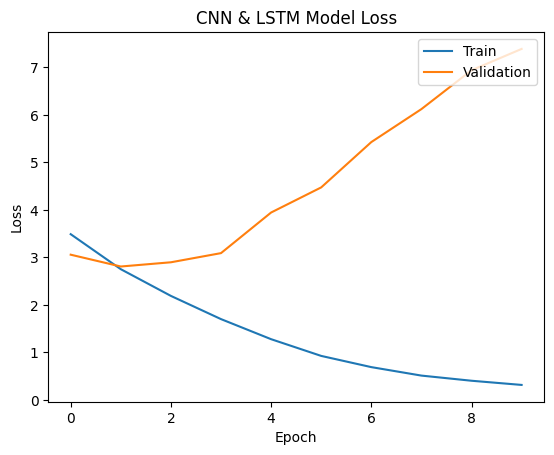

In [15]:
# Plot training & validation loss values
plt.plot(CNN_LSTM_history.history['loss'])
plt.plot(CNN_LSTM_history.history['val_loss'])
plt.title('CNN & LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
print("CNN & LSTM")
loss_and_metrics = CNN_LSTM_model.evaluate(X_test, y_test, verbose=2)
print("CNN & LSTM Test Loss", round(loss_and_metrics[0], 3))
print("CNN & LSTM Test Accuracy", round(loss_and_metrics[1], 3))

CNN & LSTM
47/47 - 0s - loss: 7.7039 - accuracy: 0.2288 - 460ms/epoch - 10ms/step
CNN & LSTM Test Loss 7.704
CNN & LSTM Test Accuracy 0.229


#### Save CNN & LSTM Model

In [18]:
CNN_LSTM_model.save('/content/cnn_lstm_model')

In [20]:
!zip -r cnn_lstm_model.zip cnn_lstm_model

  adding: cnn_lstm_model/ (stored 0%)
  adding: cnn_lstm_model/assets/ (stored 0%)
  adding: cnn_lstm_model/assets/tokens.txt (deflated 43%)
  adding: cnn_lstm_model/saved_model.pb (deflated 90%)
  adding: cnn_lstm_model/variables/ (stored 0%)
  adding: cnn_lstm_model/variables/variables.data-00000-of-00001 (deflated 68%)
  adding: cnn_lstm_model/variables/variables.index (deflated 63%)
  adding: cnn_lstm_model/keras_metadata.pb (deflated 90%)
  adding: cnn_lstm_model/fingerprint.pb (stored 0%)


In [21]:
files.download("/content/cnn_lstm_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Forest Model

#### Load prepared webTitle dataset and recode sectionName

In [10]:
X = pd.read_csv('/content/drive/MyDrive/data/X_raw_wt.csv') #WebTitle only
X.head()

,webTitle
0,saido berahino right attitude hes fit says wes...
1,angelique kerber aims dislodge serena williams...
2,family building refugee shadow isis
3,exeter keep saracens sights bonus point win wo...
4,exposed photographys fabulous fakes


In [11]:
X = X.webTitle.values

#### Encode Word Sequence Vector Representation

In [12]:
X = encode_text(X, encode_type='sequence', seq_len=237) #592 #1183 #2368 #6000 # 23677

[[11115 11116   118 ...     0     0     0]
 [11119 11120  1430 ...     0     0     0]
 [  105  1775   534 ...     0     0     0]
 ...
 [ 3954   215   252 ...     0     0     0]
 [ 1536  4797    42 ...     0     0     0]
 [11006   911 10361 ...     0     0     0]]
<class 'numpy.ndarray'>
(14983, 237)


In [23]:
y = np.argmax(y, axis=1)
print(y)
print(y.shape)

[22 67 81 ... 72 81 81]
(14983,)


#### Split webTitle & sectionName into 80% training, 10% test & 10% validation datasets

In [24]:
X_train, X_test, X_val, y_train, y_val, y_test, max_words, seq_len = train_val_test(X, y, tc=237)

** Before Truncate **
Training data shape: (11985, 237)
Training labels shape: (11985,)


Validation data shape: (1499, 237)
Validation labels shape: (1499,)


Test data shape: (1499, 237)
Test labels shape: (1499,)


** After Truncate: 237 **
Training data shape: (11985, 237)
Training labels shape: (11985,)


Validation data shape: (1499, 237)
Validation labels shape: (1499,)


Test data shape: (1499, 237)
Test labels shape: (1499,)


#### Convert into tensor datasets and create batches

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [26]:
train_dataset = train_dataset.batch(100)
val_dataset = val_dataset.batch(100)
test_dataset = test_dataset.batch(100)

#### Build Random Forest Model

In [27]:
rf_model = build_random_forest()

Use 2 thread(s) for training
Use /tmp/tmprszm1y17 as temporary training directory


#### Train Random Forest Model

In [28]:
# Train the model.
rf_history = rf_model.fit(train_dataset, validation_data=val_dataset)

Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None, 237), dtype=int32)
Label: Tensor("data_1:0", shape=(None,), dtype=int64)
Weights: None
Normalized tensor features:
 {'data:0.0': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>), 'data:0.1': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_1:0' shape=(None,) dtype=float32>), 'data:0.2': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_2:0' shape=(None,) dtype=float32>), 'data:0.3': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_3:0' shape=(None,) dtype=float32>), 'data:0.4': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_4:0' shape=(None,) dtype=float32>), 'data:0.5': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'strided_slice_5:0' shape=(None,) dtype=float32>), 'data:0.6':

[INFO 23-05-07 00:30:20.8286 UTC kernel.cc:773] Start Yggdrasil model training
[INFO 23-05-07 00:30:20.8286 UTC kernel.cc:774] Collect training examples
[INFO 23-05-07 00:30:20.8286 UTC kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-05-07 00:30:20.8344 UTC kernel.cc:393] Number of batches: 120
[INFO 23-05-07 00:30:20.8344 UTC kernel.cc:394] Number of examples: 11985
[INFO 23-05-07 00:30:20.8614 UTC kernel.cc:794] Training dataset:
Number of records: 11985
Number of columns: 238

Number of columns by type:
	NUMERICAL: 237 (99.5798%)
	CATEGORICAL: 1 (0.420168%)

Columns:

NUMERICAL: 237 (99.5798%)
	1: "data:0.0" NUMERICAL mean:3740.02 min:1 max:

Model trained in 0:04:50.221450
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [29]:
rf_model.compile(metrics=["accuracy"])

In [30]:
rf_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (237):
	data:0.0
	data:0.1
	data:0.10
	data:0.100
	data:0.101
	data:0.102
	data:0.103
	data:0.104
	data:0.105
	data:0.106
	data:0.107
	data:0.108
	data:0.109
	data:0.11
	data:0.110
	data:0.111
	data:0.112
	data:0.113
	data:0.114
	data:0.115
	data:0.116
	data:0.117
	data:0.118
	data:0.119
	data:0.12
	data:0.120
	data:0.121
	data:0.122
	data:0.123
	data:0.124
	data:0.125
	data:0.126
	data:0.127
	data:0.128
	data:0.129
	data:0.13
	data:0.130
	data:0.131
	data:0.132
	data:0.133
	data:0.134
	data:0.135
	data:0.136
	data:0.137
	data:0.138
	data:0.139
	data:0.14
	data:0.140
	data:0.141
	data:0.142
	data:0.143
	data:0.144
	data:0.145
	

In [31]:
rf_model.make_inspector().variable_importances()

{'SUM_SCORE': [("data:0.0" (1; #1), 1276792.850563841),
  ("data:0.1" (1; #2), 1209725.9603570017),
  ("data:0.2" (1; #113), 940164.443217485),
  ("data:0.4" (1; #172), 819369.6174872778),
  ("data:0.3" (1; #161), 778447.0343095136),
  ("data:0.5" (1; #183), 695820.9083138658),
  ("data:0.6" (1; #194), 639198.5806914368),
  ("data:0.7" (1; #205), 548379.5529892647),
  ("data:0.8" (1; #216), 328891.26334190555),
  ("data:0.9" (1; #227), 212515.09116994217),
  ("data:0.10" (1; #3), 66071.74969676882),
  ("data:0.11" (1; #14), 6066.39696457237),
  ("data:0.12" (1; #25), 333.56837948411703),
  ("data:0.13" (1; #36), 44.35746847093105)],
 'NUM_NODES': [("data:0.0" (1; #1), 61094.0),
  ("data:0.1" (1; #2), 58438.0),
  ("data:0.2" (1; #113), 48881.0),
  ("data:0.3" (1; #161), 48019.0),
  ("data:0.4" (1; #172), 46337.0),
  ("data:0.5" (1; #183), 41903.0),
  ("data:0.6" (1; #194), 33593.0),
  ("data:0.7" (1; #205), 24926.0),
  ("data:0.8" (1; #216), 17157.0),
  ("data:0.9" (1; #227), 9281.0),
 

#### Evaluation of Random Forest Model

In [32]:
evaluation = rf_model.evaluate(test_dataset, return_dict=True)
print()

15/15 [==============================] - 1s 22ms/step - loss: 0.0000e+00 - accuracy: 0.2168



In [33]:
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

loss: 0.0000
accuracy: 0.2168


In [34]:
tfdf.model_plotter.plot_model_in_colab(rf_model, tree_idx=0, max_depth=3)

In [35]:
rf_model.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=4385, accuracy=0.12702394526795896, loss=31.465244755152288, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=11912, accuracy=0.13398253861652115, loss=25.42511675971303, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=11984, accuracy=0.15787716955941256, loss=20.981477284607525, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=11985, accuracy=0.16821026282853566, loss=18.267726701966453, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=11985, accuracy=0.1773884021693784, loss=16.289092804051073, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=11985, accuracy=0.18272841051314143, loss=14.6936307414

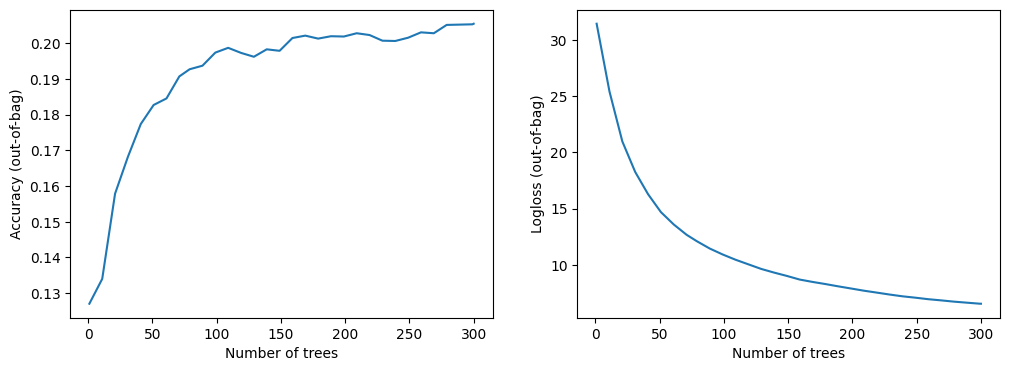

In [36]:
logs = rf_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

#### Save Random Forest Model using webTitle Bag of words 

In [37]:
rf_model.save('/content/rf_model')

In [39]:
!zip -r rf_model.zip rf_model

  adding: rf_model/ (stored 0%)
  adding: rf_model/assets/ (stored 0%)
  adding: rf_model/assets/e8970b3588d04ee8random_forest_header.pb (deflated 97%)
  adding: rf_model/assets/e8970b3588d04ee8data_spec.pb (deflated 89%)
  adding: rf_model/assets/e8970b3588d04ee8done (stored 0%)
  adding: rf_model/assets/e8970b3588d04ee8nodes-00001-of-00004 (deflated 95%)
  adding: rf_model/assets/e8970b3588d04ee8nodes-00003-of-00004 (deflated 95%)
  adding: rf_model/assets/e8970b3588d04ee8nodes-00000-of-00004 (deflated 95%)
  adding: rf_model/assets/e8970b3588d04ee8header.pb (deflated 29%)
  adding: rf_model/assets/e8970b3588d04ee8nodes-00002-of-00004 (deflated 95%)
  adding: rf_model/saved_model.pb (deflated 93%)
  adding: rf_model/variables/ (stored 0%)
  adding: rf_model/variables/variables.data-00000-of-00001 (deflated 59%)
  adding: rf_model/variables/variables.index (deflated 46%)
  adding: rf_model/keras_metadata.pb (deflated 64%)
  adding: rf_model/fingerprint.pb (stored 0%)


In [40]:
files.download("/content/rf_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>